In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
words = open('../lecture 2/names.txt').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [31]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [32]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [33]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x) , "-->" , itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [48]:
#------------------------------------------------------------------------------------------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out)) / fan_in ** 0.5 #kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
#------------------------------------------------------------------------------------------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #params (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True) #batch mean
            xvar = x.var(0,keepdim=True) #batch variance
        else: 
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
#------------------------------------------------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
#------------------------------------------------------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings,embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

#------------------------------------------------------------------------------------------------------------------------------------
class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []
#------------------------------------------------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self,layers):
        self.layers = layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        #get params of all layers and stretch them out into 1 list
        return [p for layer in self.layers for p in layer.parameters()]

In [35]:
torch.manual_seed(42); #reproducibility baby! 

In [36]:
n_embd = 10 #dimensionality of the char embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP 


model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 #last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #number of params in total

for p in parameters:
    p.requires_grad = True

12097


In [37]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


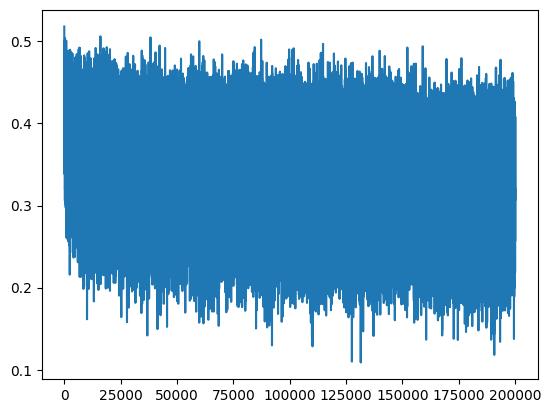

In [38]:
plt.plot(lossi)

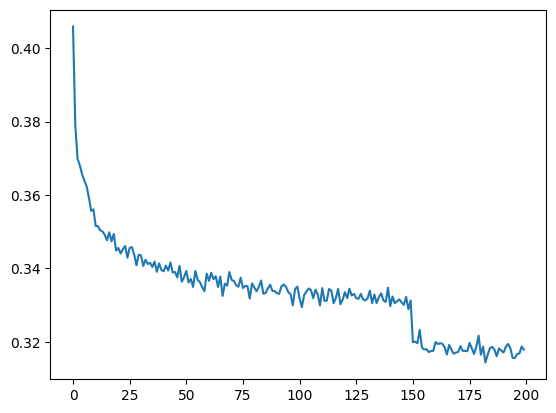

In [39]:
#well this is prettier, we see the loss plot go down as we do the learning rate decay at 150000 steps
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [40]:
#Put layers into eval mode (needed for batchnorm specifically)
for layer in model.layers:
    layer.training = False

In [41]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr,Ytr),
        "val": (Xdev,Ydev),
        "test":(Xte,Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.0583250522613525
val 2.1065292358398438


In [42]:
#sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size #init with all 
    while True: 
        #forward pass the NN 
        logits = model(torch.tensor([context]))
        
        probs = F.softmax(logits,dim=1)
        #sample from dist
        ix = torch.multinomial(probs,num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sxample the special '.' token, we break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode word and print it

damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


In [43]:
#Let's do it with a WaveNet (RNN)

In [90]:
words = open('../lecture 2/names.txt').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [91]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [92]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [93]:
#------------------------------------------------------------------------------------------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out)) / fan_in ** 0.5 #kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
#------------------------------------------------------------------------------------------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #params (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #calculate the forward pass
        if self.training:
            if x.ndim ==2:
                dim = 0
            elif x.ndim ==3:
                dim = (0,1)
            
            xmean = x.mean(dim,keepdim=True) #batch mean
            xvar = x.var(dim,keepdim=True) #batch variance
        else: 
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
#------------------------------------------------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
#------------------------------------------------------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings,embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

#------------------------------------------------------------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self,n):
        self.n = n

    def __call__(self,x):
        B, T , C = x.shape
        x = x.view(B,T //self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []
#------------------------------------------------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self,layers):
        self.layers = layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        #get params of all layers and stretch them out into 1 list
        return [p for layer in self.layers for p in layer.parameters()]

In [94]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x) , "-->" , itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [95]:
n_embd = 10 #dimensionality of the char embedding vectors
n_hidden = 68 #the number of neurons in the hidden layer of the MLP 


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 #last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #number of params in total

for p in parameters:
    p.requires_grad = True

22397


In [96]:
ix = torch.randint(0,Xtr.shape[0],(4,)) #Let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  9,  3,  5],
        [ 0,  0,  0,  5, 13, 18,  9, 11],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  5, 14, 20]])

In [97]:
print(f"Okay, we're doing a WaveNet now. its a much deeper network than the MLP you're used to. this one has: {len(model.layers)} layers\n")
for layer in model.layers:
    print(layer.__class__.__name__,":",tuple(layer.out.shape))

Okay, we're doing a WaveNet now. its a much deeper network than the MLP you're used to. this one has: 14 layers

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [100]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [76]:
logits.shape

torch.Size([4, 27])

In [72]:
model.layers[0].out.shape #Output of embedding layer

torch.Size([4, 8, 10])

In [73]:
model.layers[1].out.shape #output of flattening layer

torch.Size([4, 80])

In [74]:
model.layers[2].out.shape #output of linear layer

torch.Size([4, 200])

In [75]:
(torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [60]:
# (1 2) (3 4) (5 6) (7 8)

In [ ]:
list(range(10))[::2] #how to grab evens

[0, 2, 4, 6, 8]

In [ ]:
list(range(10))[1::2] #how to grab odds

[1, 3, 5, 7, 9]

In [63]:
e = torch.randn(4,8,10) #goal: we want this to be (4,4,20) where consecuritve 10d vectors get concatenated
e.view(e.shape[0],-1).shape

torch.Size([4, 80])

In [ ]:
torch.cat([e[:, ::2, :],e[:, 1::2, :]], dim=2 ).shape #evil shadow magic. it works? Vade retro satanus 

torch.Size([4, 4, 20])

In [101]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2539
  10000/ 200000: 2.5485
  20000/ 200000: 2.1112
  30000/ 200000: 2.0894
  40000/ 200000: 2.0998
  50000/ 200000: 1.8248
  60000/ 200000: 2.0440
  70000/ 200000: 1.8190
  80000/ 200000: 2.0495
  90000/ 200000: 2.1948
 100000/ 200000: 1.7544
 110000/ 200000: 2.0037
 120000/ 200000: 1.8848
 130000/ 200000: 2.0197
 140000/ 200000: 1.7834
 150000/ 200000: 2.1373
 160000/ 200000: 2.2972
 170000/ 200000: 1.9831
 180000/ 200000: 2.2280
 190000/ 200000: 2.3048


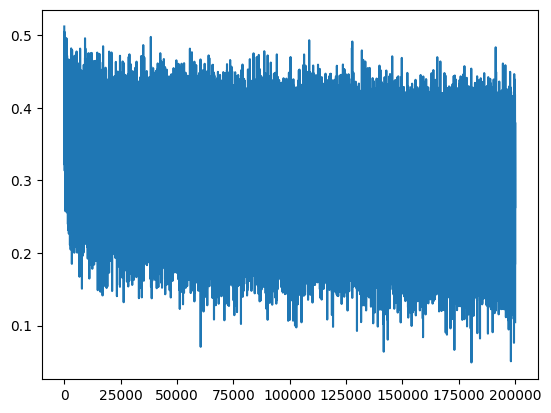

In [102]:
plt.plot(lossi)

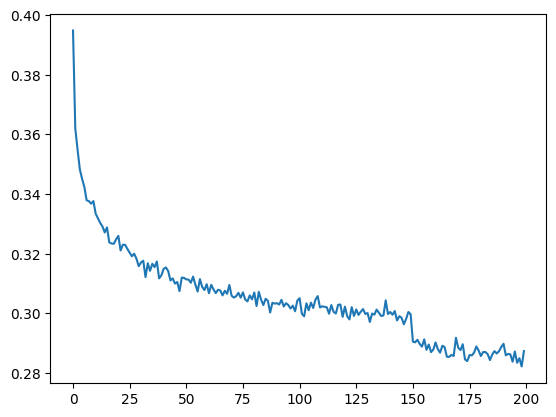

In [103]:
#well this is prettier, we see the loss plot go down as we do the learning rate decay at 150000 steps
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [104]:
#Put layers into eval mode (needed for batchnorm specifically)
for layer in model.layers:
    layer.training = False

In [105]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr,Ytr),
        "val": (Xdev,Ydev),
        "test":(Xte,Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 1.9155405759811401
val 2.019822835922241


In [106]:
#sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size #init with all 
    while True: 
        #forward pass the NN 
        logits = model(torch.tensor([context]))
        
        probs = F.softmax(logits,dim=1)
        #sample from dist
        ix = torch.multinomial(probs,num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sxample the special '.' token, we break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode word and print it

azieful.
inos.
rheas.
halen.
andiel.
rouina.
aralyn.
patriim.
danaon.
madycen.
jakin.
monika.
krio.
mcowan.
imauri.
nayloi.
natimar.
itavea.
quae.
ayasia.
